In [7]:
from pyESN import ESN

Mean Squared Error (MSE): 6.795192233327523


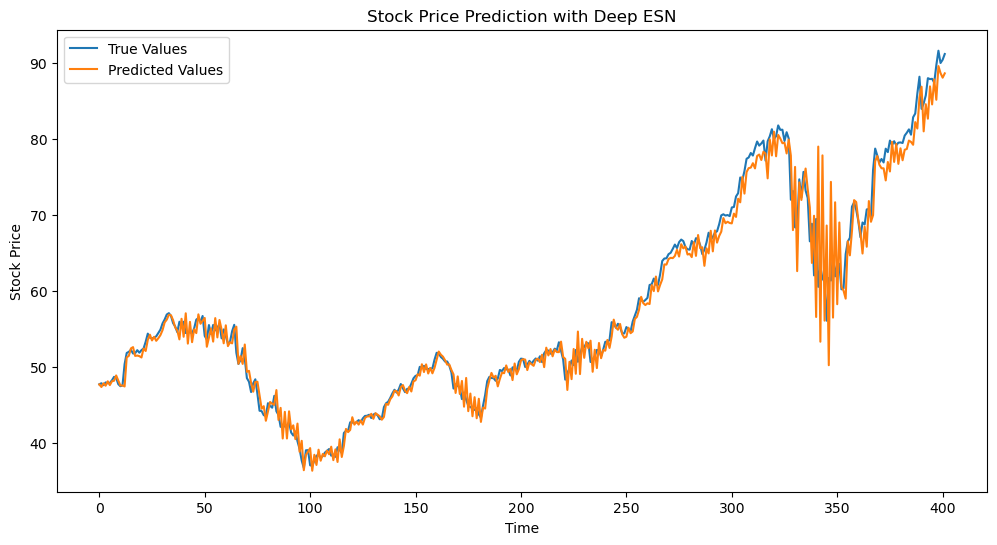

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pyESN import ESN
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Load your stock price data
# Replace 'your_data.csv' with the actual path or URL of your data file
df = pd.read_csv('apple_stocks_with_sentiment10.csv', parse_dates=['Date'])
data = df[['Close']]
# Create lagged features
def create_lagged_features(data, lag):
    for i in range(1, lag + 1):
        data[f'Close_Lag_{i}'] = data['Close'].shift(i)
    return data.dropna()

# Choose the number of lagged values to use as features
lag = 10

# Create lagged features in the DataFrame
df = create_lagged_features(data.copy(), lag)

# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Define features and target variable
X_train, y_train = train.drop([ 'Close'], axis=1), train['Close']
X_test, y_test = test.drop(['Close'], axis=1), test['Close']
# Initialize the MinMaxScaler and fit_transform on training data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define parameters
n_reservoir = 200  # Number of reservoir nodes for each layer
n_layers =4  # Number of ESN layers

# Function to create a deep ESN model
def create_deep_esn(n_layers, n_reservoir):
    deep_esn = []
    for _ in range(n_layers):
        esn = ESN(n_inputs=X_train_scaled.shape[1], n_outputs=1, n_reservoir=n_reservoir)
        deep_esn.append(esn)
    return deep_esn

# Create deep ESN model
deep_esn = create_deep_esn(n_layers, n_reservoir)

# Train the deep ESN
for esn in deep_esn:
    esn.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = np.zeros((len(y_test), 1))
for esn in deep_esn:
    y_pred += esn.predict(X_test_scaled).reshape(-1, 1)
y_pred /= n_layers

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(np.array(y_test), y_pred.flatten())
print(f'Mean Squared Error (MSE): {mse}')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(np.array(y_test), label='True Values')
plt.plot(y_pred.flatten(), label='Predicted Values')
plt.title('Stock Price Prediction with Deep ESN')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
